## Prerequisites

In [29]:
# Basic imports
import warnings
import numpy as np
import pandas as pd
from numpy import mean, std
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

# Feature selection
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from imblearn.over_sampling  import RandomOverSampler

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Ensemble techniques
from sklearn.ensemble import StackingClassifier

### Selecting the dataset

In [2]:
ds = ["./datasets/tomcat-final.csv","./datasets/struts-final.csv"]

Choose 1 for struts2-core dataset, 0 for tomcat dataset.

In [3]:
#df = pd.read_csv(ds[1])
df = pd.read_csv('./struts-final.csv')
np.set_printoptions(threshold=np.inf)
pd.set_option('max_columns',None)

In [4]:
df

,file,type,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,lcom*,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,visibleMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,title,severity,vulnerable,version
0,core/src/main/java/org/apache/struts2/views/fr...,class,5,7,2,5,14,1,0,16,0,0.583333,0.607143,1.0,8,0,8,0,0,0,8,0,0,0,3,0,0,3,0,0,0,0,0,50,8,1,3,0,1,5,7,10,4,10,2,0,0,0,50,1,0,0,0,0.0,2.3.20
1,core/src/test/java/org/apache/struts2/views/js...,class,3,3,0,3,4,4,0,14,6,0.000000,0.000000,0.0,4,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,2,53,0,0,0,0,0,11,6,12,0,12,0,0,0,0,26,1,0,0,0,0.0,2.3.20
2,plugins/cdi/src/test/java/org/apache/struts2/c...,class,8,8,0,8,4,1,0,12,6,0.000000,0.000000,0.0,4,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,1,7,0,7,0,0,0,0,35,1,0,0,0,0.0,2.3.20
3,apps/portlet/src/test/java/JettyPlutoLauncher....,class,4,4,0,4,1,1,0,7,0,0.000000,0.000000,0.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,14,0,0,0,0,0,8,2,3,0,3,0,0,0,0,26,1,0,0,0,0.0,2.3.20
4,plugins/codebehind/src/test/java/org/apache/st...,class,1,1,0,1,0,1,0,0,0,0.000000,-1.000000,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0,0.0,2.3.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,plugins/convention/src/test/java/org/apache/st...,class,0,1,1,0,1,1,0,0,0,0.000000,0.000000,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0.0,2.5.26
19368,core/src/main/java/com/opensymphony/xwork2/Act...,class,14,33,19,14,49,1,19,56,585,0.883721,0.000000,0.0,43,0,40,0,3,0,43,0,0,0,5,1,0,4,1,0,2,0,5,168,30,0,4,0,0,3,1,15,0,14,3,0,0,0,194,1,3,0,0,0.0,2.5.26
19369,apps/showcase/src/test/java/it/org/apache/stru...,class,2,13,11,2,1,2,11,3,0,0.000000,0.000000,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1025,0,0,0,0.0,2.5.26
19370,core/src/main/java/org/apache/struts2/views/xs...,class,2,3,1,2,4,1,0,8,0,0.166667,0.000000,0.0,2,0,2,0,0,0,2,0,0,0,3,1,0,2,0,1,1,0,0,22,1,0,1,0,0,7,0,5,2,5,2,0,0,0,58,1,3,0,0,0.0,2.5.26


### Data preprocessing and cleanup

In [5]:
df.loc[df['title'].str.contains('Denial', case=False),'title'] = 'DoS'
df.loc[df['title'].str.contains('CSRF', case=False),'title'] = 'CSRF'
df.loc[df['title'].str.contains('information disclosure', case=False),'title'] = 'Information Disclosure'
df.loc[df['title'].str.contains('cve-2020-9484', case=False),'title'] = 'Remote Code execution'
df.loc[df['title'].str.contains('session hijacking', case=False),'title'] = 'Remote Code execution'
df = df.drop_duplicates(keep='first').reset_index(drop=True)

Unique severities (Debugging)

In [6]:
df.severity.unique()

array(['0', 'high', 'critical', 'medium'], dtype=object)

### K-fold cross validation

In [7]:
print(f'Total number of versions / releases: {len(df.version.unique())}')

Total number of versions / releases: 11


In [8]:
train = df.loc[~(df.version=="2.3.20")]
test = df.loc[df.version=="2.3.20"]
kfold = KFold(10, shuffle=True, random_state=1)
feature_columns =df.columns[2:-4] 
print("Shape of dataframe", df.shape)

Shape of dataframe (19365, 55)


### Label encoding the string values in the columns

In [9]:
s = (train.dtypes == 'object')
object_cols = ['severity', 'title']

label_X_train = train.copy()
label_X_test = test.copy()

le = LabelEncoder()
label_X_train[object_cols] = train[object_cols].apply(le.fit_transform)
label_X_test[object_cols] = test[object_cols].apply(le.fit_transform)
print('Encoded...')

Encoded...


In [10]:
def x_y_split(index):
  y_cols = ['vulnerable','severity','title']
  X = train[feature_columns]
  test_X = test[feature_columns]
  if y_cols[index] == 'vulnerable':
    y = train[y_cols[index]]
    test_Y = test[y_cols[index]]
  else:
    y = label_X_train[y_cols[index]]
    test_Y = label_X_test[y_cols[index]]
  return X , y, test_X, test_Y

### Change target variables here.
The target variables are vulnerable, severity and title. Thus changing the value of index between 0-2 will change the target variable required for prediction.

In [41]:
X, y, test_X, test_Y = x_y_split(0)

### Random over-sampling

In [42]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

### Feature selection

#### Sequential Feature Selection

In [ ]:
sfs = SFS(LogisticRegression(), 
           k_features='best', 
           forward=True, # if forward = True then SFS otherwise SBS
           floating=False, 
           scoring='r2',
          cv=5)
sfs.fit(X,y)
sfs_features = list(sfs.k_feature_names_)
sfs_features

/Users/sundarakrishnang/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sundarakrishnang/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

['cbo']

#### Random Feature Elimination

In [43]:
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])

### Features vs rankings visualizations

In [ ]:
rfe_rankings = []
for i in range(len(X.columns)):
  rfe_rankings.append({"feature":X.columns[i], "rank":rfe.ranking_[i]})

Text(0.5, 1.0, 'Features ranked by RFE')

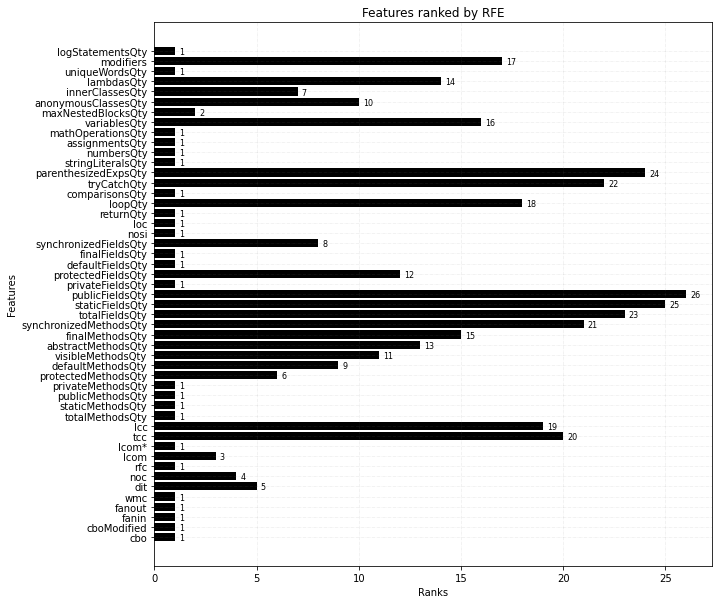

In [ ]:
ranks_df = pd.DataFrame(rfe_rankings)
features = ranks_df.feature.values[:]
ranks = ranks_df['rank'].values[:]
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(features, ranks, color='black')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.1,
             str(round((i.get_width()), 2)),
             fontsize = 8,
             color ='black')
plt.xlabel("Ranks")
plt.ylabel("Features")
plt.title("Features ranked by RFE")

fit_feature_set() - A simple function to fit a feature set.

In [44]:
def fit_feature_set(feature_set):
    X_ros = train[feature_set]
    test_X = test[feature_set]

### Machine learning

So if I run the models using cross_val_score(), ie., with k fold cross validation within themselves, then I get different accuracies for different "folds" of data.

In [45]:
fit_feature_set(rfe_features)

In [51]:
def predict(model):
  model.fit(X_ros, y_ros)
  predictions = model.predict(test_X)
  accuracy = accuracy_score(test_Y,predictions)
  precision = precision_score(test_Y, predictions, average='micro')
  recall =recall_score(test_Y, predictions)
  return [accuracy, precision, recall, predictions]

#### Decision tree classifier

In [56]:
dt = DecisionTreeClassifier(ccp_alpha=0.036)
metrics = []
for i in range(10):
  metrics.append(predict(dt)[0])
metrics

[0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943,
 0.8277216610549943]

In [57]:
dt_df = pd.DataFrame([predict(dt)[3], test_Y]).T
dt_df.columns = ['prediction', 'actual']
dt_df['prediction'] = dt_df['prediction'].astype(int)
dt_df['actual'] = dt_df['actual'].astype(int)
dt_df.loc[(dt_df['prediction'] == dt_df['actual'])]

,prediction,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1777,0,0
1778,0,0
1779,0,0
1780,0,0


#### KNN-classifier

In [62]:
metrics = []
for i in range(11,20):
  metrics.append(predict(KNN(n_neighbors=i))[0])
metrics

[0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9932659932659933,
 0.9927048260381593]

Simplifying the KNN + RFE using a pipeline

In [ ]:
rfe_ = RFE(estimator=DecisionTreeClassifier())
knn_model = KNN(metric='manhattan',algorithm='kd_tree')
pipeline = Pipeline(steps=[('s',rfe_),('m',knn_model)])
pipeline.fit(X_ros, y_ros)
y_train_pred = pipeline.predict(X_ros)
y_test_pred = pipeline.predict(test_X)
train_scores, test_scores = list(), list()
train_acc = accuracy_score(y_ros, y_train_pred)
test_acc = accuracy_score(test_Y, y_test_pred)
train_scores.append(accuracy_score(y_ros, y_train_pred))
test_scores.append(accuracy_score(test_Y, y_test_pred))
print('>%d, train: %.3f, test: %.3f' % (1, train_acc, test_acc))    

>1, train: 0.987, test: 0.994


Debugging (IGNORE)

In [64]:
knn_df = pd.DataFrame([predict(KNN(n_neighbors=20))[3], test_Y]).T
knn_df.columns = ['prediction', 'actual']
knn_df['prediction'] = knn_df['prediction'].astype(int)
knn_df['actual'] = knn_df['actual'].astype(int)

In [66]:
knn_df.loc[(knn_df['actual'] == knn_df['prediction'])]

,prediction,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1777,0,0
1778,0,0
1779,0,0
1780,0,0


In [27]:
test_X.shape[0]

1782

In [ ]:
knn_df.loc[knn_df.actual==1].shape[0]

6

In [ ]:
knn_df.loc[knn_df.prediction==1].shape[0]

14

#### Logistic regression

In [68]:
lr = LogisticRegression(solver='saga', class_weight='balanced', max_iter=4000)
metrics = []
for i in range(10):
  metrics.append(predict(lr)[0])
metrics

[0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163,
 0.8496071829405163]

#### Naive Bayes classifier

In [69]:
nb = GaussianNB()
metrics = []
for i in range(10):
  metrics.append(predict(nb)[0])
metrics

[0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401,
 0.8400673400673401]

### XGBoost classifier

In [70]:
xgb = xgb.XGBClassifier()
metrics = []
for i in range(10):
  metrics.append(predict(xgb)[0])
metrics

[0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593,
 0.9927048260381593]

In [71]:
xgb_df = pd.DataFrame([predict(xgb)[3], test_Y]).T
xgb_df.columns = ['prediction', 'actual']
xgb_df['prediction'] = xgb_df['prediction'].astype(int)
xgb_df['actual'] = xgb_df['actual'].astype(int)
xgb_df.loc[~(xgb_df['prediction'] == xgb_df['actual'])]

,prediction,actual
80,1,0
95,1,0
521,1,0
554,1,0
671,1,0
674,1,0
914,1,0
1044,1,0
1331,1,0
1334,1,0


In [ ]:
len(xgb_df.loc[xgb_df.prediction==xgb_df.actual])

1770

#### Ensemble methods
Stacking classifier

In [ ]:
def evaluate(model, X, y):
    cv = KFold(10, shuffle=True, random_state=1)
    return cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1), cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1), cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)


In [ ]:
def stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression(solver='saga',class_weight='balanced', max_iter=4000)))
    level0.append(('dt', DecisionTreeClassifier(ccp_alpha=0.036)))
    level0.append(('nb', GaussianNB()))
	
    level1 = xgb.XGBClassifier()
	
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
def get_models():
    models = dict()
    models['Decision Tree'] = DecisionTreeClassifier(ccp_alpha=0.036)
    models['Logistic Regression'] = LogisticRegression(solver='saga', class_weight='balanced', max_iter=4000)
    models['Naive Bayes'] = GaussianNB()
    models['Stacking'] = stacking()
    return models

### Stacking debug

In [ ]:
stacking_clf = stacking()
stacking_clf.fit(X_ros, y_ros)
scores = cross_val_score(stacking_clf, X_ros, y_ros, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Precision: %.3f' % mean(cross_val_score(stacking_clf, X_ros, y_ros, scoring='precision', cv=kfold, n_jobs=-1)))
print('Recall: %.3f' % mean(cross_val_score(stacking_clf, X_ros, y_ros, scoring='recall', cv=kfold, n_jobs=-1)))
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))    
st_y_train_pred = stacking_clf.predict(X_ros)
st_y_test_pred = stacking_clf.predict(test_X)
print(f'Train score {accuracy_score(st_y_train_pred,y_ros)}')
print(f'Test score {accuracy_score(st_y_test_pred,test_Y)}')

In [ ]:
st_df = pd.DataFrame([st_y_test_pred, test_Y]).T
st_df.columns = ['prediction', 'actual']
st_df['prediction'] = st_df['prediction'].astype(int)
st_df['actual'] = st_df['actual'].astype(int)
st_df.loc[(st_df['prediction']==1)&(st_df['actual']==1)]

In [ ]:
st_df.loc[st_df.prediction==1].shape[0]

In [ ]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    acc, pre, rec = evaluate(model, X_ros, y_ros)
    names.append(names)
    print('Model: %s' % (name))
    print('Accuracy: %.3f (%.3f)' % (mean(acc), std(acc)))
    print('Recall: %.3f (%.3f)' % (mean(rec), std(rec)))
    print('Precision: %.3f (%.3f) \n' % (mean(pre), std(pre)))

Model: Decision Tree
Accuracy: 0.845 (0.005)
Recall: 0.869 (0.005)
Precision: 0.830 (0.009) 

Model: Logistic Regression
Accuracy: 0.838 (0.004)
Recall: 0.835 (0.005)
Precision: 0.841 (0.006) 

Model: KNN
Accuracy: 0.998 (0.000)
Recall: 1.000 (0.000)
Precision: 0.996 (0.001) 

Model: Naive Bayes
Accuracy: 0.700 (0.009)
Recall: 0.969 (0.004)
Precision: 0.630 (0.010) 

Model: Stacking
Accuracy: 0.999 (0.001)
Recall: 1.000 (0.000)
Precision: 0.997 (0.001) 

